<a href="https://colab.research.google.com/github/aakankshch/Arkema/blob/main/CISC848Ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook is First version
It consists base model which takes MACCS Fingerprints and Molecular Transfer Embeddings and accuracy is 60%

## Loading&Exploring Data

In [ ]:
!pip install deepchem pubchempy rdkit

In [ ]:
#Installing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import RDLogger
import pubchempy as pcp
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import deepchem as dc
import torch
from transformers import BertTokenizer, BertModel,AutoTokenizer, AutoModel
#import time
#import random

In [ ]:
file_path='/content/Manual Data Scott.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Name,Canonical SMILES,k (M^-1 s^-1),pH,Rxn Type,source,Comments:
0,acetanilide,CC(=O)Nc1ccccc1,5.000000e+09,9,Addition,NIST,NaN
1,acetophenone,CC(=O)c1ccccc1,6.500000e+09,7,Addition,NIST,NaN
2,acetophenone,CC(=O)c1ccccc1,4.800000e+09,9,Addition,NIST,NaN
3,acrylamide,C=CC(N)=O,3.300000e+09,10.7,Addition,NIST,NaN
4,acrylamide,C=CC(N)=O,4.700000e+09,6,Addition,NIST,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              562 non-null    object 
 1   Canonical SMILES  562 non-null    object 
 2   k (M^-1 s^-1)     562 non-null    float64
 3   pH                562 non-null    object 
 4   Rxn Type          562 non-null    object 
 5   source            562 non-null    object 
 6   Comments:         17 non-null     object 
dtypes: float64(1), object(6)
memory usage: 30.9+ KB


In [ ]:
new_column_name = {'k (M^-1 s^-1)': 'k'}
df.rename(columns=new_column_name, inplace=True)

In [ ]:
new_order=["Name","Canonical SMILES","pH","k"]
df=df[new_order]

In [ ]:
df.head()

,Name,Canonical SMILES,pH,k
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09
4,acrylamide,C=CC(N)=O,6,4.700000e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              562 non-null    object 
 1   Canonical SMILES  562 non-null    object 
 2   pH                562 non-null    object 
 3   k                 562 non-null    float64
dtypes: float64(1), object(3)
memory usage: 17.7+ KB


In [ ]:
#Check for Missing Values
df.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0


In [ ]:
df.duplicated().sum()

3

In [ ]:
# Display duplicate rows
df[df.duplicated(keep=False)]

,Name,Canonical SMILES,pH,k
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09
147,ribose,OC1COC(O)C(O)C1O,9,2.100000e+09
149,ascorbic acid,O=C1OC(C(O)CO)C(O)=C1O,1,1.200000e+10
272,acrylamide,C=CC(N)=O,10.7,3.300000e+09
532,ascorbic acid,O=C1OC(C(O)CO)C(O)=C1O,1,1.200000e+10
536,ribose,OC1COC(O)C(O)C1O,9,2.100000e+09


In [ ]:
# Extract unique reactant names
reactant_names = df["Name"].dropna().unique()

In [ ]:
#Drop Duplicates
df = df.drop_duplicates()

In [ ]:
df.head()

,Name,Canonical SMILES,pH,k
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09
4,acrylamide,C=CC(N)=O,6,4.700000e+09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 559 entries, 0 to 561
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              559 non-null    object 
 1   Canonical SMILES  559 non-null    object 
 2   pH                559 non-null    object 
 3   k                 559 non-null    float64
dtypes: float64(1), object(3)
memory usage: 21.8+ KB


In [ ]:
df['pH'].unique()

array(['9', '7', '10.7', '6', '10.5', '3', '6.5', '2.1', '7.7', '6.3',
       '1', '1.3', '7.55', '9.3', '2', '5', '8.55', 'acid', '13', '8.5',
       '1.2', '12', '5.5', '11', '12.8', '0.1', '1.6', '10.8', '8.4',
       '0.4', '1.15', '5.9', '2.7', '8', '8.75', '4.25', '4.5', 'alk',
       '10', '6.25', '2.4', '5.75', '9.75', '6.8', '2.8', '5.8', '9.5',
       '9.8', '10.6', '6.1', '8.8', '9.2', '8.7', '8.6', '2.2', '4.2',
       '5.4', '5.25', '7.3', '5.2', '7.6', '6.4', '7.4', '7.2', '4.3',
       '6.7', '6.75', '12.4', '7.5'], dtype=object)

In [ ]:
df[df["pH"].isin(["acid", "alk"])]

,Name,Canonical SMILES,pH,k
152,Formic Acid,O=CO,acid,1.530000e+08
375,hydrogen sulfide,S,alk,9.000000e+09
538,triacetoneamine-N-oxyl,CC1(C)CC(=O)CC(C)(C)N1[O],alk,4.300000e+09


In [ ]:
df[df["pH"].isin(["acid", "alk"])].shape

(3, 4)

In [ ]:
df = df[~df["pH"].isin(["acid", "alk"])]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 561
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              556 non-null    object 
 1   Canonical SMILES  556 non-null    object 
 2   pH                556 non-null    object 
 3   k                 556 non-null    float64
dtypes: float64(1), object(3)
memory usage: 21.7+ KB


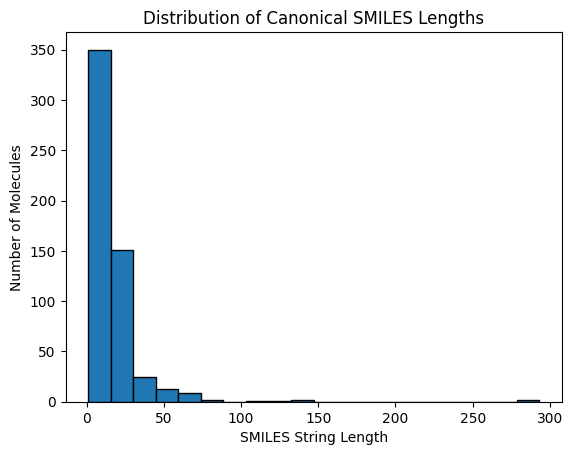

In [ ]:
df["SMILES_Length"] = df["Canonical SMILES"].apply(lambda x: len(x) if x != "Not Found" else 0)

plt.hist(df["SMILES_Length"], bins=20, edgecolor="black")
plt.xlabel("SMILES String Length")
plt.ylabel("Number of Molecules")
plt.title("Distribution of Canonical SMILES Lengths")
plt.show()


In [ ]:
df_long_smiles = df[df["SMILES_Length"] > 100]
print(df_long_smiles[["Name", "Canonical SMILES"]])

                                Name  \
463     alcoholdehydrogenase (yeast)   
464     alcoholdehydrogenase (yeast)   
465                         lysozyme   
466                         lysozyme   
467                      trypsinogen   
526  uridylyl 3' -> 5' uridine (UpU)   

                                      Canonical SMILES  
463  CCC=CCC=CCC=CCC=CCC=CCCCC(=O)CC(=O)SCCNC(=O)CC...  
464  CCC=CCC=CCC=CCC=CCC=CCCCC(=O)CC(=O)SCCNC(=O)CC...  
465  CCC(C)C(NC(=O)CNC(=O)C(CCC(N)=O)NC(=O)C1CCCN1C...  
466  CCC(C)C(NC(=O)CNC(=O)C(CCC(N)=O)NC(=O)C1CCCN1C...  
467  CC(N)C(=O)N1CCCC1C(=O)NC(Cc1ccccc1)C(=O)NC(CC(...  
526  N.O=c1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H...  


In [ ]:
len(df_long_smiles)

6

## Feature Extraction

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 0 to 561
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              556 non-null    object 
 1   Canonical SMILES  556 non-null    object 
 2   pH                556 non-null    object 
 3   k                 556 non-null    float64
 4   SMILES_Length     556 non-null    int64  
 5   Mol               553 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 46.6+ KB


In [ ]:
# Generate RDKit molecules from SMILES
df["Mol"] = df["Canonical SMILES"].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

[17:09:41] WARNING: not removing hydrogen atom without neighbors
[17:09:41] WARNING: not removing hydrogen atom without neighbors
[17:09:41] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O2'
[17:09:41] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O3'
[17:09:41] SMILES Parse Error: unclosed ring for input: 'NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC(N)OC2CO)O4'


In [ ]:
df.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7760>
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7a70>
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7ae0>
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7b50>
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7bc0>


In [ ]:
# Compute MACCS Fingerprints
def get_maccs_fingerprint(mol):
    if mol:
        return list(MACCSkeys.GenMACCSKeys(mol))  # Convert to list
    else:
        return [np.nan] * 167  # MACCS has 167 bits

In [ ]:
df["MACCS"] = df["Mol"].apply(get_maccs_fingerprint)

In [ ]:
df.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol,MACCS
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7760>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7a70>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7ae0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7b50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e37e7bc0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df.shape

(556, 7)

In [ ]:
# Convert list of fingerprints to separate columns
maccs_df = df["MACCS"].apply(pd.Series)

# Rename columns for clarity
maccs_df.columns = [f"MACCS_{i}" for i in range(167)]

# Merge with original data
df_final = pd.concat([df.drop(columns=["Mol", "MACCS"]), maccs_df], axis=1)

In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_final.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0
SMILES_Length,0
...,...
MACCS_162,3
MACCS_163,3
MACCS_164,3
MACCS_165,3


In [ ]:
df_final[df_final["MACCS_0"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
529,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,12.4,6.000000e+08,57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,9,1.000000e+13,57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,DNA,NC1CC(O)C(COP(=O)(O)OC2CC(N)OC2COP(=O)(O)OC2CC...,7.5,1.300000e+13,57,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop rows where any MACCS descriptor is NaN
df_final_cleaned = df_final.dropna()

# Reset the index after dropping rows
df_final_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
df_final_cleaned.isnull().sum().sum()

0

In [ ]:
# Convert all MACCS fingerprint columns to integers (0 or 1)
maccs_cols = [col for col in df_final_cleaned.columns if "MACCS_" in col]
df_final_cleaned[maccs_cols] = df_final_cleaned[maccs_cols].astype(int)

# Check the first few rows
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0,0,0,0,0,...,0,0,0,1,0,1,1,1,1,0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Columns: 172 entries, Name to MACCS_166
dtypes: float64(1), int64(168), object(3)
memory usage: 743.2+ KB


In [ ]:
#Molecular Transfer Embeddings
# Load pre-trained ChemBERTa model (can use other molecular transformer models too)
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
# Function to get embeddings from SMILES
def get_molecular_embedding(smiles):
    if smiles is None or smiles == "":
        return None
    try:
        tokens = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            output = model(**tokens)
        return output.last_hidden_state.mean(dim=1).squeeze().numpy()  # Get mean-pooled embedding
    except:
        return None  # Handle errors


In [ ]:
# Apply to dataset
df_final_cleaned["Transformer_Embedding"] = df_final_cleaned["Canonical SMILES"].apply(get_molecular_embedding)

In [ ]:
df_final_cleaned.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_163,MACCS_164,MACCS_165,MACCS_166,Transformer_Embedding
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,"[0.7942484, 1.4899749, -0.03859988, -0.0871674..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."


In [ ]:
df_final_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Columns: 173 entries, Name to Transformer_Embedding
dtypes: float64(1), int64(168), object(4)
memory usage: 747.5+ KB


In [ ]:
# Convert Transformer Embeddings column into separate features
embeddings_matrix = np.vstack(df_final_cleaned["Transformer_Embedding"].dropna().values)
embedding_df = pd.DataFrame(embeddings_matrix, columns=[f"Embedding_{i}" for i in range(embeddings_matrix.shape[1])])

# Merge with original dataset
df_final_embeddings = pd.concat([df_final_cleaned.reset_index(drop=True), embedding_df.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final_embeddings.drop(columns=["Transformer_Embedding"], inplace=True)

In [ ]:
df_final_embeddings.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0,0,0,0,0,...,-0.101718,0.222749,-0.814970,-0.556503,-0.263230,0.269693,-0.701040,0.058131,0.024336,0.666652
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795


In [ ]:
df_final_embeddings.isnull().sum().sum()

0

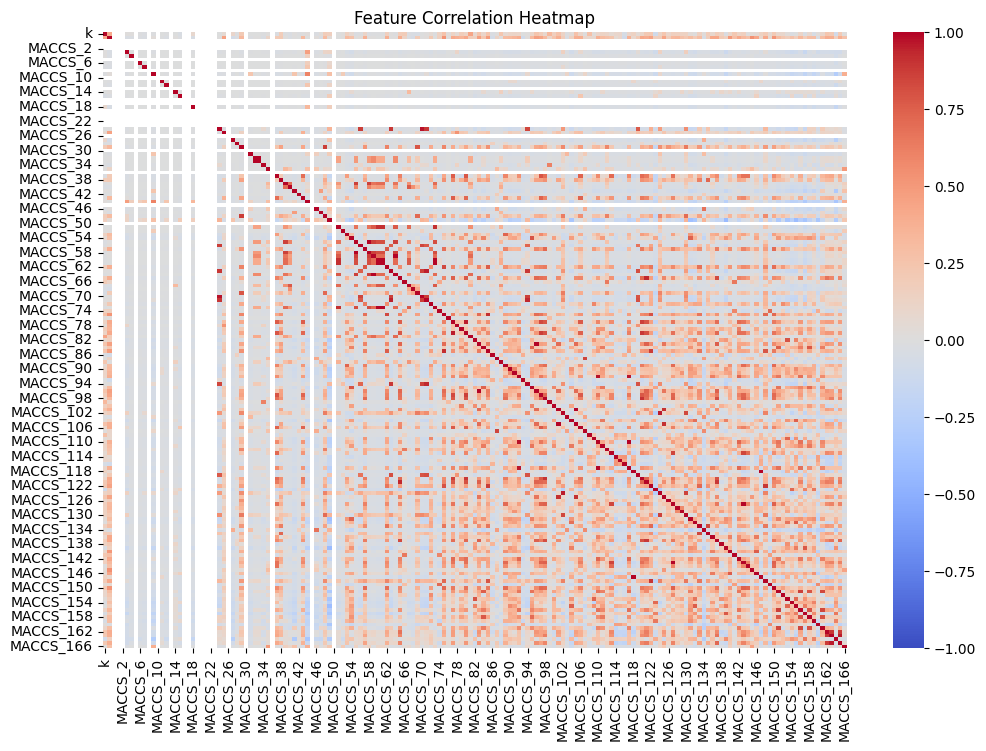

In [ ]:
# Compute correlation matrix
numerical_df_MACCS = df_final_cleaned.select_dtypes(include=["float64","int64"])
correlation_matrix = numerical_df_MACCS.corr()

# Plot heatmap of top 50 features (for visualization clarity)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", vmax=1.0, vmin=-1.0, center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert correlated pairs into a DataFrame for better visualization
correlated_df = pd.DataFrame(correlated_pairs, columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
correlated_df = correlated_df.sort_values(by="Correlation_Value", ascending=False)


In [ ]:
len(correlated_df)

51

In [ ]:
# Identify unique features to remove
features_to_remove = set(correlated_df["Feature_1"])  # Keep only one from each pair
len(features_to_remove)

# Drop correlated features from dataset
df_reduced = df_final_cleaned.drop(columns=features_to_remove)

print(f"Removed {len(features_to_remove)} correlated features.")


Removed 34 correlated features.


In [ ]:
embedding_df.head()
embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Columns: 768 entries, Embedding_0 to Embedding_767
dtypes: float32(768)
memory usage: 1.6 MB


In [ ]:
# Compute correlation matrix
correlation_matrix_em = embedding_df.corr()

# Set threshold for high correlation
corr_threshold = 0.85

# Identify highly correlated feature pairs
embedding_correlated_pairs = []

for i in range(len(correlation_matrix_em.columns)):
    for j in range(i):
        if abs(correlation_matrix_em.iloc[i, j]) > corr_threshold:
            embedding_correlated_pairs.append((correlation_matrix_em.columns[i],
                                               correlation_matrix_em.columns[j],
                                               correlation_matrix_em.iloc[i, j]))

# Convert to DataFrame for better visualization
embedding_correlated_df = pd.DataFrame(embedding_correlated_pairs,
                                       columns=["Feature_1", "Feature_2", "Correlation_Value"])

# Sort by correlation value (highest first)
embedding_correlated_df = embedding_correlated_df.sort_values(by="Correlation_Value", ascending=False)

In [ ]:
# Identify unique features to remove (keep only one from each pair)
embedding_features_to_remove = set(embedding_correlated_df["Feature_1"])

# Drop correlated features from embeddings
embeddings_df_reduced = embedding_df.drop(columns=embedding_features_to_remove)

print(f"Removed {len(embedding_features_to_remove)} correlated embedding features.")

Removed 84 correlated embedding features.


In [ ]:
embeddings_df_reduced.head()
df_reduced.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,MACCS_155,MACCS_157,MACCS_158,MACCS_159,MACCS_160,MACCS_161,MACCS_162,MACCS_164,MACCS_166,Transformer_Embedding
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,"[0.7942484, 1.4899749, -0.03859988, -0.0871674..."
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,"[0.51656204, 1.0408416, -0.106254004, -0.47288..."
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,"[0.33001658, 0.0058318377, 0.0154270595, -1.02..."


In [ ]:
# Merge with original dataset
df_final = pd.concat([df_reduced.reset_index(drop=True), embeddings_df_reduced.reset_index(drop=True)], axis=1)

# Drop original Transformer Embedding column
df_final.drop(columns=["Transformer_Embedding"], inplace=True)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Columns: 822 entries, Name to Embedding_767
dtypes: float32(684), float64(1), int64(134), object(3)
memory usage: 2.0+ MB


In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15,0,0,0,0,0,...,-0.101718,0.222749,-0.814970,-0.556503,-0.263230,0.269693,-0.701040,0.058131,0.024336,0.666652
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14,0,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14,0,0,0,0,0,...,-0.302259,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9,0,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9,0,0,0,0,0,...,0.017375,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795


## Feature Engineering

In [ ]:
# Apply natural logarithm transformation to k
df_final["ln_k"] = np.log(df_final["k"])

# Drop the original k column
df_final.drop(columns=["k"], inplace=True)

In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,...,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767,ln_k
0,acetanilide,CC(=O)Nc1ccccc1,9,15,0,0,0,0,0,0,...,0.222749,-0.814970,-0.556503,-0.263230,0.269693,-0.701040,0.058131,0.024336,0.666652,22.332704
1,acetophenone,CC(=O)c1ccccc1,7,14,0,0,0,0,0,0,...,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858,22.595068
2,acetophenone,CC(=O)c1ccccc1,9,14,0,0,0,0,0,0,...,0.151909,-0.842064,-1.164823,-0.132765,0.188541,-0.758128,0.060318,0.368453,0.306858,22.291882
3,acrylamide,C=CC(N)=O,10.7,9,0,0,0,0,0,0,...,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795,21.917188
4,acrylamide,C=CC(N)=O,6,9,0,0,0,0,0,0,...,1.039670,-0.706766,0.181418,0.581395,1.091526,-0.075132,-0.598901,0.599155,0.827795,22.270828


In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify columns to scale
embedding_cols = [col for col in df_final.columns if "Embedding_" in col]

# Initialize Scaler
scaler = StandardScaler()

# Apply Scaling to Embeddings Only
df_final[embedding_cols] = scaler.fit_transform(df_final[embedding_cols])

In [ ]:
df_final.head()

,Name,Canonical SMILES,pH,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,...,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767,ln_k
0,acetanilide,CC(=O)Nc1ccccc1,9,15,0,0,0,0,0,0,...,-0.720470,-1.119685,-0.239638,-0.416129,0.321723,-0.513751,1.157884,0.060816,0.738984,22.332704
1,acetophenone,CC(=O)c1ccccc1,7,14,0,0,0,0,0,0,...,-0.854476,-1.173998,-1.519939,-0.040898,0.192796,-0.648593,1.163201,0.948909,-0.434050,22.595068
2,acetophenone,CC(=O)c1ccccc1,9,14,0,0,0,0,0,0,...,-0.854476,-1.173998,-1.519939,-0.040898,0.192796,-0.648593,1.163201,0.948909,-0.434050,22.291882
3,acrylamide,C=CC(N)=O,10.7,9,0,0,0,0,0,0,...,0.824866,-0.902775,1.313430,2.013096,1.627380,0.964643,-0.440020,1.544301,1.264360,21.917188
4,acrylamide,C=CC(N)=O,6,9,0,0,0,0,0,0,...,0.824866,-0.902775,1.313430,2.013096,1.627380,0.964643,-0.440020,1.544301,1.264360,22.270828


In [ ]:
# Ensure MACCS fingerprints are integers (binary features)
maccs_cols = [col for col in df_final.columns if "MACCS_" in col]
df_final[maccs_cols] = df_final[maccs_cols].astype(int)

# Ensure embedding columns are floats
embedding_cols = [col for col in df_final.columns if "Embedding_" in col]
df_final[embedding_cols] = df_final[embedding_cols].astype(float)

In [ ]:
#Ensuring proper Data Types
df_final["pH"] = df_final["pH"].astype(float)

In [ ]:
print(df_final.dtypes)

Name                 object
Canonical SMILES     object
pH                  float64
SMILES_Length         int64
MACCS_0               int64
                     ...   
Embedding_764       float64
Embedding_765       float64
Embedding_766       float64
Embedding_767       float64
ln_k                float64
Length: 822, dtype: object


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Columns: 822 entries, Name to ln_k
dtypes: float64(686), int64(134), object(2)
memory usage: 3.5+ MB


## Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

In [ ]:
# Define input features (excluding non-numeric columns)
X = df_final.drop(columns=["Name", "Canonical SMILES", "ln_k"])  # Features
y = df_final["ln_k"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,pH,SMILES_Length,MACCS_0,MACCS_1,MACCS_2,MACCS_3,MACCS_4,MACCS_5,MACCS_6,MACCS_7,...,Embedding_758,Embedding_759,Embedding_760,Embedding_761,Embedding_762,Embedding_763,Embedding_764,Embedding_765,Embedding_766,Embedding_767
18,9.0,21,0,0,0,0,0,0,0,0,...,2.122935,0.295495,0.058209,-0.140238,1.618503,0.832916,0.352157,0.356433,1.073963,0.036753
325,10.7,10,0,0,0,1,0,0,0,0,...,1.213875,0.554463,1.111999,0.007059,2.083167,-0.027125,1.897787,-0.982755,1.948760,0.117954
486,9.0,38,0,0,0,0,0,0,0,0,...,0.451755,-0.746571,1.763403,0.058681,-0.833847,-0.098304,0.430153,0.958457,-0.269277,-0.491587
296,7.0,48,0,0,0,0,0,0,0,0,...,0.274167,0.800246,2.946813,0.370495,0.759781,0.073554,1.460388,1.898924,-1.353091,-0.041883
478,5.5,16,0,0,0,0,0,0,0,0,...,-0.501873,-1.032735,0.407550,-1.109242,1.104718,-0.337349,0.350121,1.232213,0.645856,0.601086


In [ ]:
# Initialize models
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)  # Alpha controls regularization strength
ridge_model = Ridge(alpha=1.0)

In [ ]:
# Train models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

Ridge()

In [ ]:
# Make predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

In [ ]:
# Evaluate models
results = {
    "Model": ["Linear Regression", "Lasso Regression", "Ridge Regression"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_linear),
        mean_absolute_error(y_test, y_pred_lasso),
        mean_absolute_error(y_test, y_pred_ridge),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_linear)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_linear),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_ridge),
    ],
}

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [ ]:
display(results_df)

,Model,MAE,RMSE,R² Score
0,Linear Regression,1.105355,1.665417,0.419253
1,Lasso Regression,1.236581,1.812853,0.311877
2,Ridge Regression,0.994102,1.642240,0.435305


In [ ]:
# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
# Evaluate models
results_tree = {
    "Model": ["Random Forest", "XGBoost"],
    "MAE": [
        mean_absolute_error(y_test, y_pred_rf),
        mean_absolute_error(y_test, y_pred_xgb),
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    ],
    "R² Score": [
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_xgb),
    ],
}

In [ ]:
results_tree

{'Model': ['Random Forest', 'XGBoost'],
 'MAE': [0.8464987886224786, 0.8672743974164112],
 'RMSE': [1.4106339116028621, 1.4974541174339584],
 'R² Score': [0.5833520510840786, 0.5304869620627715]}

In [ ]:
# Convert results to a DataFrame
results_tree = pd.DataFrame(results_tree)
display(results_tree)

,Model,MAE,RMSE,R² Score
0,Random Forest,0.846499,1.410634,0.583352
1,XGBoost,0.867274,1.497454,0.530487


In [ ]:
# Merge the results
final_results = pd.concat([results_df, results_tree], ignore_index=True)

In [ ]:
display(final_results)

,Model,MAE,RMSE,R² Score
0,Linear Regression,1.105355,1.665417,0.419253
1,Lasso Regression,1.236581,1.812853,0.311877
2,Ridge Regression,0.994102,1.642240,0.435305
3,Random Forest,0.846499,1.410634,0.583352
4,XGBoost,0.867274,1.497454,0.530487


### Delete Later

In [ ]:
# Define the molecular descriptors to compute
descriptor_names = [desc[0] for desc in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

In [ ]:
# Compute descriptors and store them in a new DataFrame
descriptor_data = []
for mol in df["Mol"]:
    if mol:
        descriptor_data.append(calculator.CalcDescriptors(mol))
    else:
        descriptor_data.append([None] * len(descriptor_names))

[17:11:56] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 72, in SPS
    return _SpacialScore(mol, normalize=normalize).score
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 95, in __init__
    self.score /= self.mol.GetNumHeavyAtoms()
ZeroDivisionError: division by zero
[17:11:56] WARNING: not removing hydrogen atom without neighbors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/rdkit/Chem/SpacialScore.py", line 72, in SP

In [ ]:
# Convert to DataFrame
descriptor_df = pd.DataFrame(descriptor_data, columns=descriptor_names)

# Merge with the original data
df_descriptors = pd.concat([df.drop(columns=["Mol"]), descriptor_df], axis=1)

In [ ]:
df_descriptors.head()

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,acetanilide,CC(=O)Nc1ccccc1,9,5.000000e+09,15.0,10.502041,10.502041,0.035926,-0.035926,0.622799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,acetophenone,CC(=O)c1ccccc1,7,6.500000e+09,14.0,10.645370,10.645370,0.120926,0.120926,0.517047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,acetophenone,CC(=O)c1ccccc1,9,4.800000e+09,14.0,10.645370,10.645370,0.120926,0.120926,0.517047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,acrylamide,C=CC(N)=O,10.7,3.300000e+09,9.0,9.472222,9.472222,0.481481,-0.481481,0.421996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,acrylamide,C=CC(N)=O,6,4.700000e+09,9.0,9.472222,9.472222,0.481481,-0.481481,0.421996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df[df["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol


In [ ]:
df_descriptors[df_descriptors["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
152,NaN,NaN,NaN,NaN,NaN,8.361111,8.361111,0.250000,-0.250000,0.380161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,NaN,NaN,NaN,NaN,NaN,9.062500,9.062500,0.625000,0.625000,0.399917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375,NaN,NaN,NaN,NaN,NaN,4.122685,4.122685,0.194444,0.194444,0.430050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532,NaN,NaN,NaN,NaN,NaN,9.997826,9.997826,0.668633,-2.221748,0.237891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536,NaN,NaN,NaN,NaN,NaN,12.408729,12.408729,0.029454,-1.347366,0.284676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
538,NaN,NaN,NaN,NaN,NaN,12.530603,12.530603,0.037140,-1.168657,0.614448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.iloc[[152, 272, 375, 532, 536, 538]]  # Check if these rows exist in df

,Name,Canonical SMILES,pH,k,SMILES_Length,Mol
153,Formic Acid,O=CO,7,2.760000e+09,4,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3803d10>
274,N-methylformamide,CNC=O,5.5,1.200000e+09,5,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3823220>
378,t-butylmercaptan,CC(C)(C)S,7,1.800000e+10,9,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3845fc0>
537,sucrose,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,2,2.500000e+09,39,<rdkit.Chem.rdchem.Mol object at 0x7fc5e3842420>
542,eosin dianion,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,9,6.000000e+08,65,<rdkit.Chem.rdchem.Mol object at 0x7fc5e38425e0>
544,fluoroscein,O=C1OC2(c3ccc(O)cc3Oc3cc(O)ccc32)c2ccccc21,9.2,1.400000e+09,42,<rdkit.Chem.rdchem.Mol object at 0x7fc5e38426c0>


In [ ]:
#Dropping the probablamatic names
df_descriptors = df_descriptors.dropna(subset=["Name"])

In [ ]:
df_descriptors[df_descriptors["Name"].isnull()]

,Name,Canonical SMILES,pH,k,SMILES_Length,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [ ]:
# Check how many descriptors are NaN
df_descriptors.isnull().sum()

,0
Name,0
Canonical SMILES,0
pH,0
k,0
SMILES_Length,0
...,...
fr_thiazole,9
fr_thiocyan,9
fr_thiophene,9
fr_unbrch_alkane,9
